## First I load the 2021 data (json format)
    * I need to plot the phase as func of freq to make sure the data looks like the generated data.

## Second part, I load the 2022 data

In [1]:
import json
import os
import numpy as np

def load_json(path):
    data_dir = {}
    # first load all data
    for root, dirs, files in os.walk(path):
        if 'ClosedLoopResponse_Environment.json' not in files:
            continue
        file = os.path.join(root, 'ClosedLoopResponse_Environment.json')
        print('Reading data from: ', file)
        with open(file) as jsonfile:
            try:
                data = json.load(jsonfile)
                beam_line = file.split('/')[-2]
                data_dir[beam_line+'_21'] = {
                    'y': np.array(data['environment']['prm']['fit_prm']['TF']['H'], dtype=complex),
                    'freq': np.array(data['environment']['prm']['fit_prm']['TF']['freq'], dtype=float)
                }
            except json.JSONDecodeError as e:
                print(f'[ERROR] File {file}, produced error: {e}')
    return data_dir

In [9]:
data_dir = load_json('/home/kiliakis/work/data-llrf/2021')

Reading data from:  /home/kiliakis/work/data-llrf/2021/3B2/ClosedLoopResponse_Environment.json
Reading data from:  /home/kiliakis/work/data-llrf/2021/5B0/ClosedLoopResponse_Environment.json
[ERROR] File /home/kiliakis/work/data-llrf/2021/5B0/ClosedLoopResponse_Environment.json, produced error: Expecting value: line 1 column 1 (char 0)
Reading data from:  /home/kiliakis/work/data-llrf/2021/4B1/ClosedLoopResponse_Environment.json
Reading data from:  /home/kiliakis/work/data-llrf/2021/1B1/ClosedLoopResponse_Environment.json
Reading data from:  /home/kiliakis/work/data-llrf/2021/5B2/ClosedLoopResponse_Environment.json
Reading data from:  /home/kiliakis/work/data-llrf/2021/3B1/ClosedLoopResponse_Environment.json
Reading data from:  /home/kiliakis/work/data-llrf/2021/8B2/ClosedLoopResponse_Environment.json
Reading data from:  /home/kiliakis/work/data-llrf/2021/2B2/ClosedLoopResponse_Environment.json
Reading data from:  /home/kiliakis/work/data-llrf/2021/8B1/ClosedLoopResponse_Environment.jso

In [10]:
print(data_dir.keys())

dict_keys(['3B2_21', '4B1_21', '1B1_21', '5B2_21', '3B1_21', '8B2_21', '2B2_21', '8B1_21', '6B1_21', '7B2_21', '1B2_21', '6B2_21', '4B2_21', '7B1_21', '5B1_21', '2B1_21'])


In [11]:
# convert to dB
for k, v in data_dir.items():
    data_dir[k]['amplitude'] = 20 * np.log10(np.abs(v['y']))
    data_dir[k]['real'] = v['y'].real
    data_dir[k]['imag'] = v['y'].imag
    del data_dir[k]['y']


In [12]:
import pandas as pd
df = pd.DataFrame.from_dict(data_dir, orient='index')
df.head()

,freq,amplitude,real,imag
3B2_21,"[-1619443.359375, -1614550.78125, -1609658.203...","[-21.777909296765575, -15.057012209125634, -14...","[0.08133579725841898, 0.051474840390077534, 0....","[0.005011469983590167, -0.16899911501622603, 0..."
4B1_21,"[-1619443.359375, -1614550.78125, -1609658.203...","[-16.549652269096566, -20.01969655997585, -20....","[-0.026679795952774418, -0.07647726969086971, ...","[-0.1463588317648657, -0.06407789716197017, 0...."
1B1_21,"[-1619443.359375, -1614550.78125, -1609658.203...","[-20.2673641620488, -19.779742221907256, -18.4...","[0.09695721712767796, 0.09919239881532062, 0.0...","[-0.0014954233612149335, -0.026098106680390566..."
5B2_21,"[-1619443.359375, -1614550.78125, -1609658.203...","[-13.816465626241573, -19.706971066659623, -25...","[0.15931370325321093, 0.06474392932533353, -0....","[-0.12707608641609552, -0.08066121124737649, -..."
3B1_21,"[-1619443.359375, -1614550.78125, -1609658.203...","[-14.487696517960305, -27.50301068354199, -27....","[0.1625850605118769, 0.01047347697587523, 0.03...","[-0.09564568737505466, -0.04083323830963009, 0..."


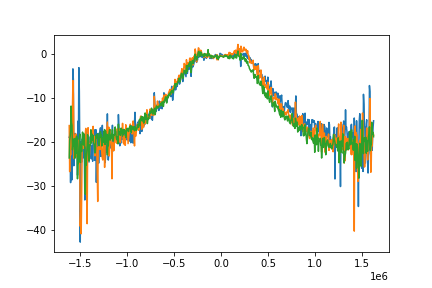

In [115]:
%matplotlib widget
from matplotlib import pyplot as plt

# visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    plt.plot(x, y)
plt.show()

In [13]:
# save dataframe to file
df.to_pickle('./data/tf-measurement-2021.pkl')

In [70]:
# freq seems to be a bit off
freqs = np.zeros((len(df), len(df.x[0])), dtype=np.float32)
index = 0
for _, row in df.iterrows():
    freqs[index, :] = row.values[1]
    index+=1
# assert all freqs are equal
np.unique(np.diff(freqs), axis=1)
x = df.iloc[0].x.astype(np.float32)
df = df.drop(columns='x')

In [71]:
df.head()

,y
3B2,"[-21.777909296765575, -15.057012209125634, -14..."
4B1,"[-16.549652269096566, -20.01969655997585, -20...."
1B1,"[-20.2673641620488, -19.779742221907256, -18.4..."
5B2,"[-13.816465626241573, -19.706971066659623, -25..."
3B1,"[-14.487696517960305, -27.50301068354199, -27...."


In [4]:
import os
import numpy as np

def load_npz(path):
    data_dir = {}
    # first load all data
    for root, dirs, files in os.walk(path):
        for file in files:
            if 'closed_loop_response__transfer_function__' not in file:
                continue

            file = os.path.join(root, file)
            print('Reading data from: ', file)
            try:
                beam_line = file.split('/')[-2]
                timestamp = file.split('_function__')[1].split('.npz')[0]
                data = np.load(file)
                # print(list(data.keys()))
                data_dir[beam_line+'_'+timestamp] = {
                    'y': np.array(data['h'], dtype=complex),
                    'freq': np.array(data['freq'], dtype=float)
                }
            except Exception as e:
                print(f'[ERROR] File {file}, produced error: {e}')

    return data_dir

In [5]:
data_dir_2022 = load_npz('/home/kiliakis/work/data-llrf/2022')
# convert to dB
for k, v in data_dir_2022.items():
    data_dir_2022[k]['amplitude'] = 20 * np.log10(np.abs(v['y']))
    data_dir_2022[k]['real'] = v['y'].real
    data_dir_2022[k]['imag'] = v['y'].imag
    del data_dir_2022[k]['y']
    exit()

Reading data from:  /home/kiliakis/work/data-llrf/2022/acquisition_data/3B2/closed_loop_response__transfer_function__220412_173447.npz
['h', 'freq', 'sp_out_iq', 'q_cl']
Reading data from:  /home/kiliakis/work/data-llrf/2022/acquisition_data/3B2/closed_loop_response__transfer_function__220412_173834.npz
['h', 'freq', 'sp_out_iq', 'q_cl']
Reading data from:  /home/kiliakis/work/data-llrf/2022/acquisition_data/3B2/closed_loop_response__transfer_function__220412_171151.npz
['h', 'freq', 'sp_out_iq', 'q_cl']
Reading data from:  /home/kiliakis/work/data-llrf/2022/acquisition_data/3B2/closed_loop_response__transfer_function__220412_174043.npz
['h', 'freq', 'sp_out_iq', 'q_cl']
Reading data from:  /home/kiliakis/work/data-llrf/2022/acquisition_data/3B2/closed_loop_response__transfer_function__220412_171806.npz
['h', 'freq', 'sp_out_iq', 'q_cl']
Reading data from:  /home/kiliakis/work/data-llrf/2022/acquisition_data/3B2/closed_loop_response__transfer_function__220412_174519.npz
['h', 'freq', '

KeyboardInterrupt: 

In [16]:
import pandas as pd
df22 = pd.DataFrame.from_dict(data_dir_2022, orient='index')
df22.head()

,freq,amplitude,real,imag
3B2_220412_173447,"[-1619443.359375, -1614550.78125, -1609658.203...","[-24.51491888231732, -18.586843008533414, -19....","[0.04803403102605476, 0.07095516661786772, 0.0...","[-0.03505279045500576, -0.09386740251265056, 0..."
3B2_220412_173834,"[-1619443.359375, -1614550.78125, -1609658.203...","[-16.983423382785222, -20.326042606836452, -22...","[0.1208846452155351, 0.08535173379101775, 0.07...","[-0.07359231304242166, -0.04462991275357435, 0..."
3B2_220412_171151,"[-1619443.359375, -1614550.78125, -1609658.203...","[-23.129462016787343, -14.875370553975397, -19...","[0.04122786632321749, 0.10797230864446494, 0.0...","[-0.05625777875663823, -0.14451775700575686, -..."
3B2_220412_174043,"[-1619443.359375, -1614550.78125, -1609658.203...","[-16.101513872082162, -20.602523606631745, -14...","[0.12378911431373243, 0.07270099721798444, 0.1...","[0.09599369330201799, 0.05847342440315569, -0...."
3B2_220412_171806,"[-1619443.359375, -1614550.78125, -1609658.203...","[-18.955587103610682, -24.970713252863305, -23...","[0.11269946501388299, 0.05619516329746758, 0.0...","[-0.0041819362473564286, -0.005077227372012491..."


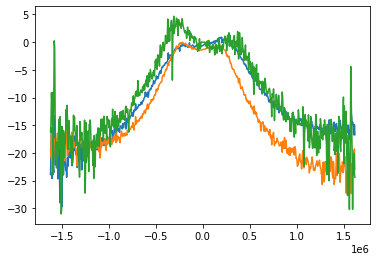

In [107]:
%matplotlib inline

from matplotlib import pyplot as plt

for index, row in df22.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    # label = f'm{m}-s{s}'
    plt.plot(x, y)
plt.show()

In [108]:
# save dataframe to file
df22.to_pickle('./data/tf-measurement-2022.pkl')

In [98]:
# freq seems to be a bit off
freqs = np.zeros((len(df22), len(df22.x[0])), dtype=np.float32)
index = 0
for _, row in df22.iterrows():
    freqs[index, :] = row.values[1]
    index+=1
# assert all freqs are equal
print(np.unique(np.diff(freqs), axis=1))
x = df22.iloc[0].x.astype(np.float32)

df22 = df22.drop(columns='x')

[[4892.5    4892.5625 4892.578  4892.5938 4892.625  9785.156 ]
 [4892.5    4892.5625 4892.578  4892.5938 4892.625  9785.156 ]
 [4892.5    4892.5625 4892.578  4892.5938 4892.625  9785.156 ]
 ...
 [4892.5    4892.5625 4892.578  4892.5938 4892.625  9785.156 ]
 [4892.5    4892.5625 4892.578  4892.5938 4892.625  9785.156 ]
 [4892.5    4892.5625 4892.578  4892.5938 4892.625  9785.156 ]]


In [109]:
print(df22.shape)

(452, 2)
